In [460]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import soundfile as sf
import pretty_midi
import matplotlib.colors as mcolors
import matplotlib.patches as patches

In [461]:
note_freqs = {
    "C4": 261.63,
    "C#4": 277.18,
    "D4": 293.66,
    "D#4": 311.13,
    "E4": 329.63,
    "F4": 349.23,
    "F#4": 369.99,
    "G4": 392.00,
    "G#4": 415.30,
    "A4": 440.00,
    "A#4": 466.16,
    "B4": 493.88,

    "C5": 523.25,
    "C#5": 554.37,
    "D5": 587.33,
    "D#5": 622.25,
    "E5": 659.26,
    "F5": 698.46,
    "F#5": 739.99,
    "G5": 783.99,
    "G#5": 830.61,
    "A5": 880.00,
    "A#5": 932.33,
    "B5": 987.77,

    "C6": 1046.50,
    "C#6": 1108.73,
    "D6": 1174.66,
    "D#6": 1244.51,
    "E6": 1318.51,
    "F6": 1396.91,
    "F#6": 1479.98,
    "G6": 1567.98,
    "G#6": 1661.22,
    "A6": 1760.00,
    "A#6": 1864.66,
    "B6": 1975.53
}


In [462]:
general_dir = "Melodies" # directory for all melodies
melody_name = "Elise" # melody name
chords_output_filename = "chords"
reconstructed_audio_filename = "reconstructed"

is_visualized = False # inner processing process will be shown on graphs
is_played = True # recognized notes will be transformed to sound in .wav file
is_written_to_text_notes = True # the file with text note labels will be generated
is_written_to_graph_notes = True # notes timing diagram will be generated

seconds_per_chord = 0.1 # duration of each chord ~ segment length

amplitude_min_threshold = 20 # noise filtration
freq_min_threshold = 100
freq_max_threshold = 450

eps_dbscan = 10 # the more these values are
min_samples = 1 # the more notes are in a chord

In [463]:
general_dir += "/"
melody_dir = melody_name + "/"
melody_name += ".mp3"

chords_output_filename += ".txt"
chords_output_filepath = general_dir + melody_dir + chords_output_filename

reconstructed_audio_filename += ".wav"
reconstructed_audio_filepath = general_dir + melody_dir + reconstructed_audio_filename

In [464]:
def freq_to_note_label(freq, note_freqs, tolerance=10):
    closest_note = None
    min_diff = tolerance + 1
    for note, note_freq in note_freqs.items():
        diff = abs(freq - note_freq)
        if diff < min_diff:
            min_diff = diff
            closest_note = note
    return closest_note if min_diff <= tolerance else None

In [465]:
def visualise(segments_filtered_freqs, segments_filtered_ampls, segments_clustered_freqs, segments_clustered_ampls, display_freq, is_visualized):
    if not is_visualized: return

    indices_to_display = list(range(0, len(segments_filtered_freqs), display_freq))
    num_to_display = len(indices_to_display)

    fig, axes = plt.subplots(num_to_display, 2, figsize=(14, 3 * num_to_display))
    if num_to_display == 1:
        axes = np.array([axes])

    for ax_idx, i in enumerate(indices_to_display):
        # Before clustering
        ax_orig = axes[ax_idx, 0]
        ax_orig.bar(segments_filtered_freqs[i], segments_filtered_ampls[i], width=5)
        ax_orig.set_title(f"Сегмент {i + 1} — до кластеризации")
        ax_orig.set_xlabel("Частота (Гц)")
        ax_orig.set_ylabel("Амплитуда")
        ax_orig.grid(True)

        # After clustering
        ax_cluster = axes[ax_idx, 1]
        if len(segments_filtered_freqs[i]) == 0:
            ax_cluster.set_title(f"Сегмент {i + 1} — пустой")
            ax_cluster.axis('off')
            continue

        if len(segments_clustered_freqs[i]) == 0:
            ax_cluster.set_title(f"Сегмент {i + 1} — все точки шум")
            ax_cluster.axis('off')
            continue

        ax_cluster.bar(segments_clustered_freqs[i], segments_clustered_ampls[i], width=5)
        ax_cluster.set_title(f"Сегмент {i + 1} — после DBSCAN")
        ax_cluster.set_xlabel("Частота (Гц)")
        ax_cluster.set_ylabel("Максимальная амплитуда")
        ax_cluster.grid(True)

        # Note labels
        note_labels_cluster = []
        note_positions_cluster = []
        for freq in segments_clustered_freqs[i]:
            label = freq_to_note_label(freq, note_freqs)
            if label:
                note_labels_cluster.append(label)
                note_positions_cluster.append(freq)

        ax_cluster.set_xticks(note_positions_cluster)
        ax_cluster.set_xticklabels(note_labels_cluster, rotation=45, fontsize=8)

    plt.tight_layout()
    plt.show()


In [466]:
def sound_generation(segments_clustered_freqs, segments_clustered_ampls, is_played):
    if not is_played: return

    duration = segment_length / sr  # длительность одного сегмента (в секундах)
    time = np.linspace(0, duration, segment_length, endpoint=False)
    reconstructed_segments = []

    for i in range(num_segments):
        if len(segments_clustered_freqs[i]) == 0:
            reconstructed_segments.append(np.zeros_like(segment))
            continue

        # Sound generation
        segment_signal = np.zeros(segment_length)
        for freq, amp in zip(segments_clustered_freqs[i], segments_clustered_ampls[i]):
            segment_signal += amp * np.sin(2 * np.pi * freq * time)
        segment_signal /= np.max(np.abs(segment_signal) + 1e-9)
        reconstructed_segments.append(segment_signal)

    # Segments union
    reconstructed_audio = np.concatenate(reconstructed_segments)
    sf.write(reconstructed_audio_filepath, reconstructed_audio, sr)
    print("✅ Аудио сохранено как " + reconstructed_audio_filepath)


In [467]:
def chords_to_text(segments_clustered_freqs, is_written_to_text_notes, is_written_to_graph_notes):
    if not is_written_to_text_notes: return

    with open(chords_output_filepath, "w", encoding="utf-8") as f:
        chords = []
        for i in range(len(segments_clustered_freqs)):
            chord_notes = []
            for freq in segments_clustered_freqs[i]:
                note = freq_to_note_label(freq, note_freqs)
                if note:
                    chord_notes.append(note)
            chords.append(chord_notes)

            if chord_notes:
                f.write(f"Сегмент {i+1}: [{', '.join(chord_notes)}]\n")
            else:
                f.write(f"Сегмент {i+1}: [не определено]\n")
    print("✅ Аккорды сохранены как " + chords_output_filepath)

    if is_written_to_graph_notes:
        visualize_notes(chords)


In [468]:
def visualize_notes(chords, rect_height=1.0, fig_width=12):
    note_range = [pretty_midi.note_number_to_name(n) for n in range(60, 90)]
    note_to_index = {note: i for i, note in enumerate(note_range)}
    n_notes = len(note_range)
    n_segments = len(chords)

    matrix = np.zeros((n_notes, n_segments), dtype=int)
    for t, chord in enumerate(chords):
        for note in chord:
            if note in note_to_index:
                i = note_to_index[note]
                matrix[i, t] = 1

    segment_ids = np.arange(n_segments)
    np.random.seed(42)
    np.random.shuffle(segment_ids)
    segment_color_map = {original_idx: shuffled_idx for original_idx, shuffled_idx in zip(np.arange(n_segments), segment_ids)}

    cmap = plt.colormaps['nipy_spectral'].resampled(n_segments)
    norm = mcolors.Normalize(vmin=0, vmax=n_segments - 1)

    # Рассчитываем высоту фигуры так, чтобы прямоугольники не сжимались
    fig_height = (n_segments * rect_height) * 0.2 + 2  # Эмпирическая формула (можно настроить)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Фон (горизонтальные полосы)
    for t in range(n_segments):
        color_idx = segment_color_map[t]
        base_color = cmap(norm(color_idx))
        light_color = tuple(0.1 * np.array(base_color[:3]) + 0.9 * np.array([1, 1, 1]))
        rect = patches.Rectangle(
            (-0.5, t * rect_height - 0.5 * rect_height),  # y = t * rect_height
            width=n_notes,
            height=rect_height,
            color=light_color,
            zorder=0
        )
        ax.add_patch(rect)

    # Ноты (цветные квадраты)
    for t in range(n_segments):
        for i in range(n_notes):
            if matrix[i, t] == 1:
                color_idx = segment_color_map[t]
                rect = patches.Rectangle(
                    (i - 0.5, t * rect_height - 0.5 * rect_height),
                    width=1,
                    height=rect_height,
                    color=cmap(norm(color_idx)),
                    zorder=1
                )
                ax.add_patch(rect)

    ax.set_xlim(-0.5, n_notes - 0.5)
    ax.set_ylim(-0.5 * rect_height, n_segments * rect_height - 0.5 * rect_height)
    ax.set_xticks(np.arange(n_notes))
    ax.set_xticklabels(note_range, rotation=90)

    # Настройка оси Y (сегменты)
    step = max(1, n_segments // 20)  # Автоподбор шага для подписей
    yticks = np.arange(0, n_segments, step)
    ytick_labels = [str(i + 1) for i in yticks]
    ax.set_yticks(yticks * rect_height)  # Учитываем высоту прямоугольников
    ax.set_yticklabels(ytick_labels)

    plt.xlabel("Ноты")
    plt.ylabel("Сегменты")
    plt.title("Цветная матрица нот (фиксированная высота прямоугольников)")
    plt.tight_layout()
    plt.show()

✅ Аудио сохранено как Melodies/Elise/reconstructed.wav
✅ Аккорды сохранены как Melodies/Elise/chords.txt


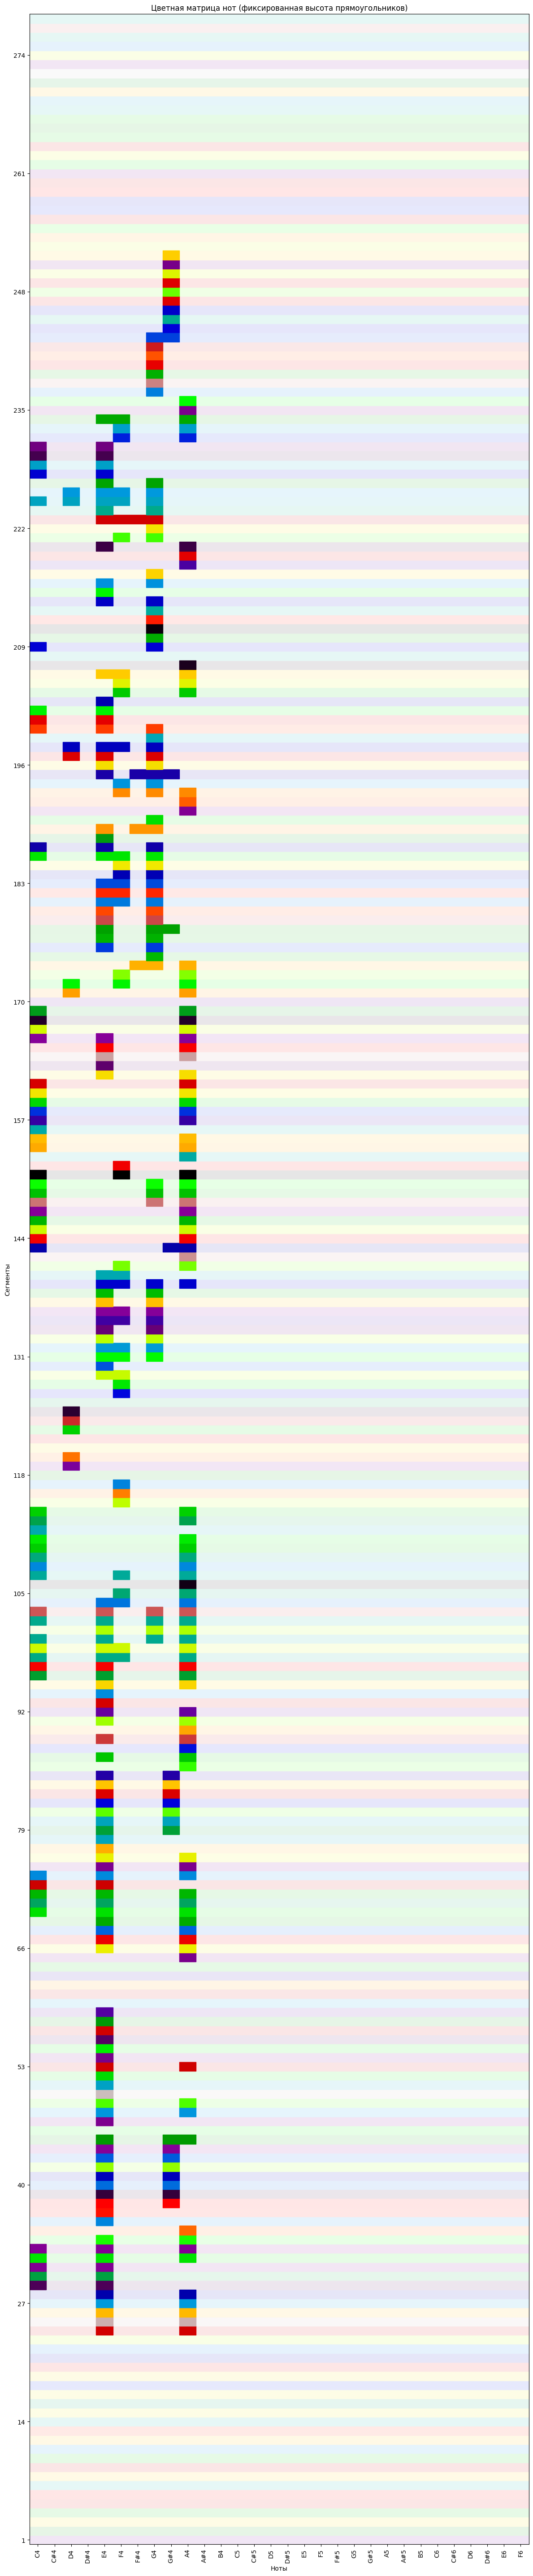

In [469]:
audio_path = general_dir + melody_dir + melody_name
amplitudes, sr = librosa.load(audio_path, sr=None, mono=True)

melody_duration = len(amplitudes) / sr
num_segments = int( melody_duration / seconds_per_chord )
segment_length = len(amplitudes) // num_segments

segments_filtered_freqs = []
segments_filtered_ampls = []
segments_clustered_freqs = []
segments_clustered_ampls = []

for i in range(num_segments):
    start = i * segment_length
    end = len(amplitudes) if i == num_segments - 1 else (i + 1) * segment_length
    segment = amplitudes[start:end]

    n = len(segment)
    freqs = np.fft.fftfreq(n, d=1/sr)
    fft_vals = np.abs(np.fft.fft(segment))

    # Only positive freqs
    freqs = freqs[:n // 2]
    fft_vals = fft_vals[:n // 2]

    # Remove weal freqs
    mask = (fft_vals >= amplitude_min_threshold) & (freqs <= freq_max_threshold) & (freqs >= freq_min_threshold)
    filtered_freqs = freqs[mask]
    filtered_fft_vals = fft_vals[mask]
    segments_filtered_freqs.append(filtered_freqs)
    segments_filtered_ampls.append(filtered_fft_vals)

    if len(filtered_freqs) == 0:
        segments_clustered_freqs.append(np.array([]))
        segments_clustered_ampls.append(np.array([]))
        continue

    # Clustering
    dbscan = DBSCAN(eps=eps_dbscan, min_samples=min_samples)
    labels = dbscan.fit_predict(filtered_freqs.reshape(-1, 1))

    unique_labels = set(labels)
    unique_labels.discard(-1)

    cluster_freqs = []
    cluster_amps = []

    for label in unique_labels:
        freqs_cluster = filtered_freqs[labels == label]
        amps_cluster = filtered_fft_vals[labels == label]

        if len(freqs_cluster) == 0:
            continue

        idx_max = np.argmax(amps_cluster)
        cluster_freqs.append(freqs_cluster[idx_max])
        cluster_amps.append(amps_cluster[idx_max])

    if not cluster_freqs:
        segments_clustered_freqs.append(np.array([]))
        segments_clustered_ampls.append(np.array([]))
        continue

    cluster_freqs = np.array(cluster_freqs)
    cluster_amps = np.array(cluster_amps)
    sorted_idx = np.argsort(cluster_freqs)
    cluster_freqs = cluster_freqs[sorted_idx]
    cluster_amps = cluster_amps[sorted_idx]

    segments_clustered_freqs.append(cluster_freqs)
    segments_clustered_ampls.append(cluster_amps)

visualise(segments_filtered_freqs, segments_filtered_ampls, segments_clustered_freqs, segments_clustered_ampls, 2, is_visualized)
sound_generation(segments_clustered_freqs, segments_clustered_ampls, is_played)
chords_to_text(segments_clustered_freqs, is_written_to_text_notes, is_written_to_graph_notes)